In [149]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
import numpy as np
import pandas as pd
import visualkeras as vk


In [130]:
data = pd.read_csv("smart_building_cleaned.csv")
data

,light,temperature,co2,pir,humidity,room,weekday,time
0,97.0,23.94,495.0,0,45.34,413,2,1
1,6.0,25.18,476.0,0,47.90,413,1,5
2,5.0,25.00,463.0,0,47.93,413,1,6
3,4.0,24.85,448.0,0,48.16,413,1,6
4,5.0,24.59,456.0,0,48.32,413,1,7
...,...,...,...,...,...,...,...,...
128257,33.0,22.94,500.0,0,56.76,776,2,17
128258,157.0,23.16,504.0,0,56.42,776,2,18
128259,141.0,23.43,497.0,0,55.86,776,2,18
128260,129.0,23.55,508.0,0,55.73,776,2,19


In [131]:
train_data = data.sample(frac=0.8, random_state=42).drop(columns=["room"], axis=1)
test_data = data.drop(train_data.index).drop(columns=["room"], axis=1)

train_data

,light,temperature,co2,pir,humidity,weekday,time
53224,4.0,22.59,284.0,0,57.75,2,20
83416,3.0,23.27,320.0,0,58.24,4,18
3945,119.0,23.65,898.0,1,55.51,1,21
34081,4.0,21.24,354.0,0,61.70,1,12
124507,4.0,24.06,515.0,0,55.33,1,6
...,...,...,...,...,...,...,...
126805,62.0,23.32,609.0,0,55.51,1,18
24044,4.0,23.46,417.0,0,58.05,1,2
48435,43.0,23.92,504.0,1,55.08,6,19
72179,14.0,22.81,121.0,0,58.61,4,16


In [132]:
test_data

,light,temperature,co2,pir,humidity,weekday,time
2,5.0,25.00,463.0,0,47.93,1,6
5,5.0,24.56,447.0,0,48.25,1,7
15,5.0,24.85,486.0,0,43.75,5,6
18,3.0,24.59,474.0,0,43.98,5,7
20,3.0,24.42,496.0,0,44.08,5,8
...,...,...,...,...,...,...,...
128239,5.0,24.46,545.0,0,53.88,2,4
128244,4.0,24.20,526.0,0,54.64,2,6
128252,4.0,23.80,527.0,0,55.55,2,9
128254,4.0,23.66,527.0,0,55.83,2,11


In [133]:
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop("pir")
test_labels = test_features.pop("pir")

In [134]:
vector = np.vectorize(np.float)

C:\Users\ziadh\AppData\Local\Temp\ipykernel_18060\2829588490.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vector = np.vectorize(np.float)


In [135]:
train_features = vector(train_features)

In [136]:
train_features = np.asarray(train_features).astype(np.int_)
# X=train_features.to_list()

In [137]:
# train_labels = tf.convert_to_tensor(train_labels)

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

In [138]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [139]:
normalizer.adapt(tf.convert_to_tensor(train_features))

In [140]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [141]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 53ms/step


array([[ 0.5265928 ],
       [ 0.53441906],
       [ 1.6150059 ],
       [ 0.65182805],
       [-0.6213112 ],
       [-1.9699819 ],
       [-1.3635921 ],
       [-1.4180013 ],
       [ 0.72098386],
       [ 1.524958  ]], dtype=float32)

In [147]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      Dense(64, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dropout(0.5, noise_shape = None, seed = 42),
      Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["accuracy"])
  return model

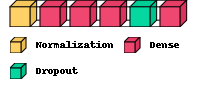

In [148]:
dnn_model = build_and_compile_model(normalizer)
vk.layered_view(dnn_model,legend=True, draw_volume=True)


In [57]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: total: 9min 32s
Wall time: 1min 1s


In [60]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
print(f"MSE: {test_results[0]}\nAccuracy: {test_results[1]*100}")

MSE: 0.034444473683834076
Accuracy: 96.89692854881287
